In [1]:

import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import arviz
import os
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import pyro.contrib.examples.util  # patches torchvision
from pyro.contrib.examples.util import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import copy
from IPython.display import clear_output


/home/pants007/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pants007/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/pants007/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


# B.1

## Data

In [2]:
def f(x):
    return torch.sin(20 * x) + 2 * torch.cos(14 * x) - 2 * torch.sin(6 * x)
X = torch.tensor([-1, -1/2, 0, 1/2, 1])
y = f(X)
x = torch.tensor([-1/4])
XNew = torch.linspace(-1, 1, steps=200)

## Gaussian process definition

In [3]:
def make_gpr(X,y, default = True, kernel = None, prior_dict = None):
    pyro.clear_param_store()
    if default:
        kernel = gp.kernels.RBF(input_dim=1)
        kernel.variance = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
        kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
    else:
        #assert kernel is not None
        assert isinstance(prior_dict, dict)
        for attr,prior in prior_dict.items():
            setattr(kernel, attr, prior)
    return gp.models.GPRegression(X, y, kernel, noise=torch.tensor(10**(-4)))

## MCMC hyper-parameters

In [4]:
C = 4
W = 10
N = 500
#C = 2
#W = 1
#N = 4

## Sampling posterior of GP with MCMC

In [5]:
def mcmc_sampler(gpr, C, W, N):
    nuts_kernel = pyro.infer.NUTS(gpr.model, jit_compile = True, ignore_jit_warnings=True)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=N,
                        num_chains=C, warmup_steps = W)
    mcmc.run()
    return mcmc

In [6]:
gpr = make_gpr(X, y)
mcmc = mcmc_sampler(gpr, C, W, N)

Warmup [1]:   0%|          | 0/510 [00:00, ?it/s]


/home/pants007/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:276: UserWarning: operator() profile_node %1383 : int[] = prim::profile_ivalue(%1381)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/pants007/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:276: UserWarning: operator() profile_node %1383 : int[] = prim::profile_ivalue(%1381)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/pants007/.local/lib/python3.10/site-packages/torch/autograd/__init__.py:276: UserWarning: operator() profile_node %1383 : int[] = prim::profile_ivalue(%1381)
 does not have profi

## Estimates of mean and variance based on samples

In [7]:
def predictive(x, gpr, prior_dict = None):
    if prior_dict is None:
        gpr.kernel.variance = pyro.nn.module.PyroSample(dist.LogNormal(-1.0, 1.0))
        gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))
    else:
        assert isinstance(prior_dict, dict)
        for attr,prior in prior_dict.items():
            setattr(gpr.kernel, attr, prior)
    loc, cov = gpr(x, noiseless = False, full_cov = True)
    var = cov.diag()
    pyro.sample("loc", dist.Delta(loc))
    pyro.sample("var", dist.Delta(var))
    pyro.sample("f", dist.Normal(loc, var))

In [8]:
def sample_predict(x, gpr, mcmc, default = True, prior_dict = None):
    posterior_samples=mcmc.get_samples(group_by_chain=True)
    posterior_samples_flat = {k : v.flatten() for (k,v) in posterior_samples.items()}
    posterior_predictor = pyro.infer.Predictive(predictive, posterior_samples = posterior_samples_flat)
    posterior_predictive = posterior_predictor(x,gpr, prior_dict)
    return posterior_predictive, posterior_samples

In [9]:
posterior_predictive, posterior_samples = sample_predict(x, gpr, mcmc)
posterior_locs = posterior_predictive['loc']
posterior_vars = posterior_predictive['var']
posterior_lengthscale = posterior_samples['kernel.lengthscale']
posterior_variance = posterior_samples['kernel.variance']

## A scatter plot on log-log scale of N = 500 samples from $P(\theta | \mathcal{D})$

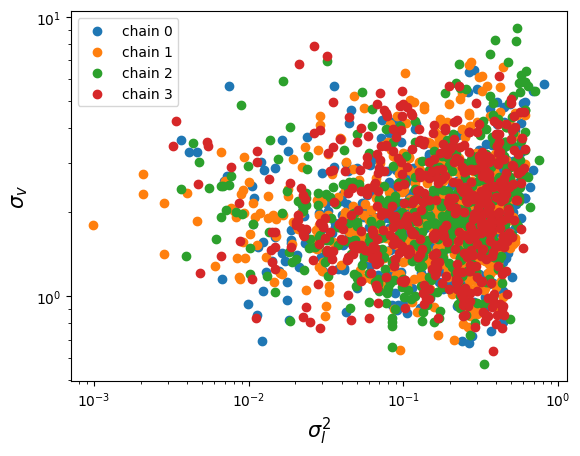

In [10]:
for c in range(C):
    plt.scatter(posterior_lengthscale[c],posterior_variance[c], label = "chain " + str(c))
plt.xlabel(r"$\sigma_l^2$", fontsize = 15)
plt.ylabel(r"$\sigma_v$", fontsize=15)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

## Sample quality analysis

                     mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
kernel.lengthscale  0.218  0.159     0.003      0.508      0.008    0.006   
kernel.variance     2.204  1.089     0.773      4.469      0.036    0.029   

                    ess_bulk  ess_tail  r_hat  
kernel.lengthscale     306.0     424.0   1.01  
kernel.variance       1099.0     812.0   1.01  


/home/pants007/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/pants007/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/pants007/.local/lib/python3.10/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


array([<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
       <AxesSubplot: title={'center': 'kernel.variance'}>], dtype=object)

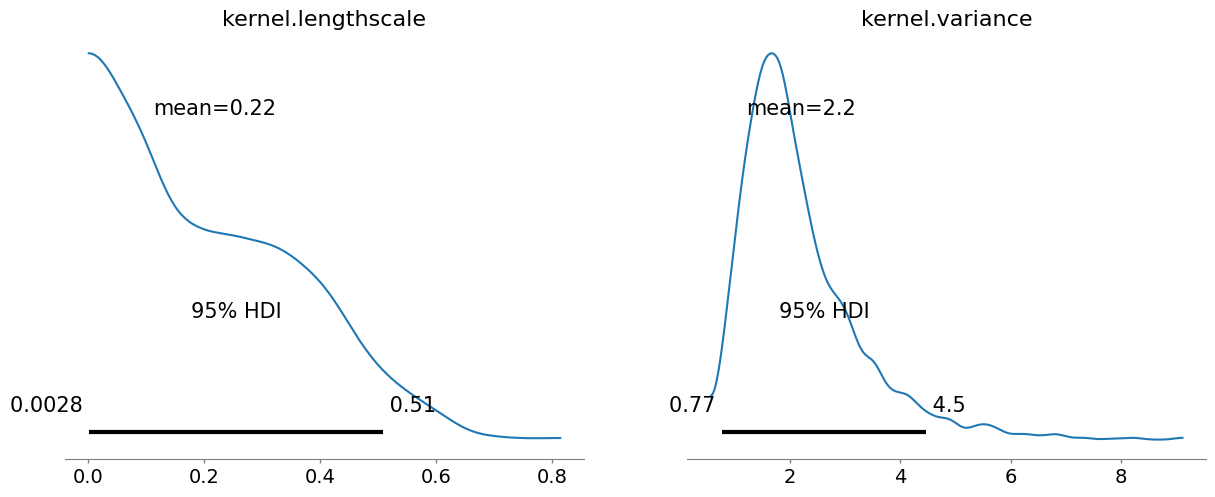

In [11]:
data = arviz.from_pyro(mcmc)
summary = arviz.summary(data, hdi_prob=0.95)
print(summary)
arviz.plot_posterior(data, hdi_prob=0.95)


## Plot visualizing $p(f^* | x^*, \mathcal{D})$

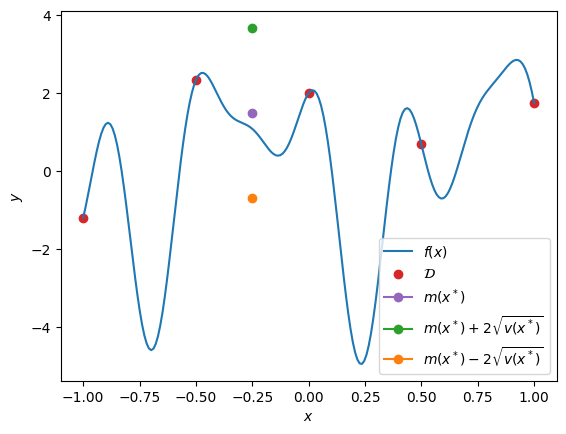

In [12]:
plt.plot(XNew, f(XNew), label = r"$f(x)$")
plt.scatter(X, y, color = 'tab:red', label = r"$\mathcal{D}$")
plt.plot(x, posterior_locs.mean(), color = 'tab:purple', label = r"$m(x^*)$", marker = "o")
plt.plot(x, posterior_locs.mean() + 2*np.sqrt(posterior_vars.mean()), color='tab:green', label=r"$m(x^*) + 2\sqrt{v(x^*)}$", marker="o")
plt.plot(x, posterior_locs.mean() -2*np.sqrt(posterior_vars.mean()), color='tab:orange', label=r"$m(x^*) -2\sqrt{v(x^*)}$", marker="o")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()

# B.2

## Algorithm definition

In [13]:
def algorithm1(X, y, XNew, T, C=C, W=W, N = N, prior_dict = None):
    X_aug = torch.cat((X, torch.empty(T)))
    y_aug = torch.cat((y, torch.empty(T)))
    X_dim = X.shape[0]
    y_dim = y.shape[0]
    stats = torch.empty((T, 3, XNew.shape[0]))
    minima = torch.empty((T, 2))
    mcmc = None
    #clear_output(wait=True)
    for k in range(T):
        pyro.clear_param_store()
        print("Iteration " + str(k+1) + "/" + str(T))
        X_k = X_aug[:X_dim + k]
        y_k = y_aug[:y_dim + k]
        gpr = make_gpr(X_k, y_k, prior_dict = prior_dict)
        mcmc = mcmc_sampler(gpr, C, W, N)
        posterior_predictive, _ = sample_predict(XNew, gpr, mcmc, prior_dict = prior_dict)
        fs = posterior_predictive['f'].mean(dim=0)
        ps = torch.argmin(fs)
        X_min = XNew[ps]
        y_min = f(X_min)
        X_aug[X_dim+k] = X_min
        y_aug[y_dim+k] = y_min
        print(posterior_predictive['loc'].mean(dim=0).shape)
        stats[k, 0, :] = posterior_predictive['loc'].mean(dim=0)
        stats[k, 1, :] = posterior_predictive['var'].mean(dim=0)
        stats[k, 2, :] = fs
        minima[k, 0] = X_min
        minima[k, 1] = y_min
    return stats, minima, mcmc

## Algorithm hyper-parameters

In [14]:
T = 10
C = 1
N = 10
W = 10

## Running the algorithm

In [15]:
stats, minima = algorithm1(X, y, XNew, T, C, W, N)


Iteration 1/10


Sample: 100%|██████████| 20/20 [00:00, 32.96it/s, step size=2.23e-01, acc. prob=0.802]


torch.Size([200])
Iteration 2/10


Sample: 100%|██████████| 20/20 [00:00, 29.48it/s, step size=1.88e-01, acc. prob=0.970]


torch.Size([200])
Iteration 3/10


Sample: 100%|██████████| 20/20 [00:00, 24.40it/s, step size=1.25e-01, acc. prob=0.991]


torch.Size([200])
Iteration 4/10


Sample: 100%|██████████| 20/20 [00:00, 32.04it/s, step size=2.88e-01, acc. prob=0.730]


torch.Size([200])
Iteration 5/10


Sample: 100%|██████████| 20/20 [00:00, 26.31it/s, step size=9.60e-02, acc. prob=0.982]


torch.Size([200])
Iteration 6/10


Sample: 100%|██████████| 20/20 [00:00, 28.78it/s, step size=2.29e-01, acc. prob=0.861]


torch.Size([200])
Iteration 7/10


Sample: 100%|██████████| 20/20 [00:00, 31.20it/s, step size=1.58e-01, acc. prob=0.892]


torch.Size([200])
Iteration 8/10


Sample: 100%|██████████| 20/20 [00:00, 30.20it/s, step size=1.91e-01, acc. prob=0.748]


torch.Size([200])
Iteration 9/10


Sample: 100%|██████████| 20/20 [00:00, 29.15it/s, step size=1.16e-01, acc. prob=0.980]


torch.Size([200])
Iteration 10/10


Sample: 100%|██████████| 20/20 [00:00, 27.77it/s, step size=1.72e-01, acc. prob=0.921]


torch.Size([200])


## B.2-1 plotting

In [16]:
stats.shape

torch.Size([10, 3, 200])

### Plot of f and f*

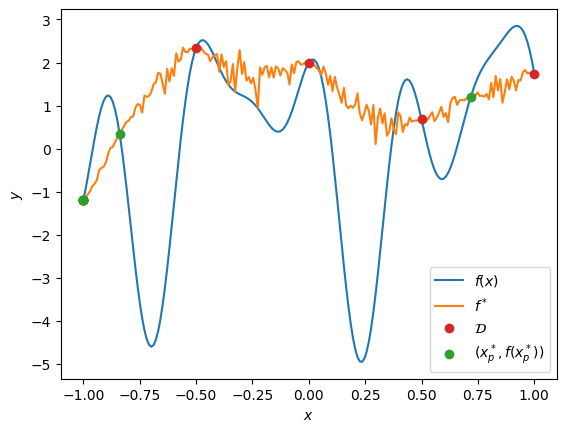

In [17]:
plt.plot(XNew, f(XNew), label = r"$f(x)$")
plt.plot(XNew, stats[9,2,:], label= r"$f^*$")
plt.scatter(X, y, color = 'tab:red', label = r"$\mathcal{D}$", zorder=4)
plt.scatter(minima[:,0], minima[:,1], color = 'tab:green', label = r"$(x^*_p, f(x^*_p))$", zorder=4)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()

### Plot of f and confidence intervals

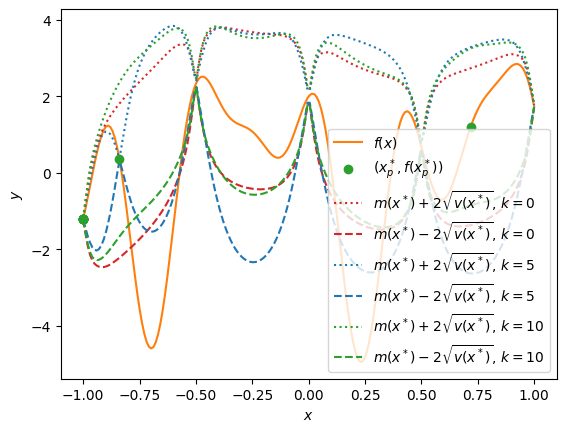

In [18]:
plt.plot(XNew, f(XNew), label = r"$f(x)$", color='tab:orange')
plt.scatter(minima[:,0], minima[:,1], color = 'tab:green', label = r"$(x^*_p, f(x^*_p))$", zorder=4)
plt.plot(XNew, stats[0,0,:] + 2 * np.sqrt(stats[0,1,:]), label=r"$m(x^*) + 2\sqrt{v(x^*)}$, $k=0$", linestyle='dotted', color='tab:red')
plt.plot(XNew, stats[0,0,:] - 2 * np.sqrt(stats[0,1,:]), label=r"$m(x^*) - 2\sqrt{v(x^*)}$, $k=0$", linestyle='dashed', color='tab:red')
plt.plot(XNew, stats[4,0,:] + 2 * np.sqrt(stats[4,1,:]), label=r"$m(x^*) + 2\sqrt{v(x^*)}$, $k=5$", linestyle='dotted', color='tab:blue')
plt.plot(XNew, stats[4,0,:] - 2 * np.sqrt(stats[4,1,:]), label=r"$m(x^*) - 2\sqrt{v(x^*)}$, $k=5$", linestyle='dashed', color='tab:blue')
plt.plot(XNew, stats[9,0,:] + 2 * np.sqrt(stats[0,1,:]), label=r"$m(x^*) + 2\sqrt{v(x^*)}$, $k=10$", linestyle='dotted', color='tab:green')
plt.plot(XNew, stats[9,0,:] - 2 * np.sqrt(stats[0,1,:]), label=r"$m(x^*) - 2\sqrt{v(x^*)}$, $k=10$", linestyle='dashed', color='tab:green')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.legend()
plt.show()

## Trying different kernels / grid search of priors

In [19]:
range = torch.linspace(start=-5., end=5., steps=10)
for x in enumerate(range):
    for y in enumerate(range[1:]):
        prior_dict = {'variance': }


SyntaxError: expression expected after dictionary key and ':' (741043647.py, line 4)